# CIFAR 100 dataset - Image recognition 

## Submitted by: Group 7

Source:  http://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR datasets are labeled subsets of the 80 million tiny images dataset
collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The images are of size 32x32 pixels with 3 color channels (RGB).It comprises of 100 classes containing 600 images each (500 training and 100 testing).

The classes (fine labels) are grouped into 20 superclasses (coarse labels) and corresponding classes. Group 7 has chosen the below subset of the data.

### Medium-sized mammals -
fox, porcupine, possum, raccoon, skunk

### Small mammals -
hamster, mouse, rabbit, shrew, squirrel


## Data Preparation

In [0]:
# Install keras and dill
!pip install dill
!pip install -q keras

In [0]:
# Import packages and modules
from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [0]:
# Set tensorflow in the backend
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

In [0]:
# Smaller batch size means more updates in one epoch
batch_size = 256
num_classes = 100
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar100'
'''

'\nepochs_longrun = 500\nsave_dir = "/work"\nres_dir = "/results"\nmodel_name = \'convnet_cifar100\'\n'

In [0]:
# Load data and set a seed for reproducibility of results
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)

# The data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()   # point!!!!
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train_c = to_categorical(y_train, num_classes)
y_test_c = to_categorical(y_test, num_classes)
#Normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0    
x_test /= 255.0

In [0]:
# Check the unique values in training set
np.unique(y_train)        # target is hundred classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

### Combine the training and test data back into one data

In [0]:
# Use concatenate function to merge the two sets
x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test)) # for ten class

print('x shape:', x.shape)
print('multiple y shape:', y.shape)

x shape: (60000, 3, 32, 32)
multiple y shape: (60000, 1)


### Filter out the assigned superclasses

In [0]:
# First and foremost, define fine labels
fine_label = [
'apple',                                         # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

# For the above fine labels, find the index of relevant sub-classes
medium_sized_mammals_index = [ fine_label.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
small_mammals_index = [ fine_label.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]
target_index = medium_sized_mammals_index + small_mammals_index

print ("Index of Medium-sized mammals:", medium_sized_mammals_index,"\nIndex of Small mammals:", small_mammals_index)

Index of Medium-sized mammals: [34, 63, 64, 66, 75] 
Index of Small mammals: [36, 50, 65, 74, 80]


In [0]:
# Splice the dataset to extract the relevant portion of data
train_slice = np.array([ idx for idx, y in enumerate(y_train) if y[0] in target_index ])
y_train = y_train[train_slice]
x_train = x_train[train_slice]

test_slice = np.array([ idx for idx, y in enumerate(y_test) if y[0] in target_index ])
y_test = y_test[test_slice]
x_test = x_test[test_slice]

slice = np.array([ idx for idx, y in enumerate(y) if y[0] in target_index ])
y = y[slice]
x = x[slice]

print (np.unique(y_train) )
print (np.unique(y_test) )

[34 36 50 63 64 65 66 74 75 80]
[34 36 50 63 64 65 66 74 75 80]


In [0]:
#  Binary as we are working with two superclasses labels (or coarse labels)
y_train_bin = np.array([[int(y[0] in medium_sized_mammals_index)] for y in y_train ])
y_test_bin = np.array([[int(y[0] in medium_sized_mammals_index)] for y in y_test ])
y_bin = np.concatenate((y_train_bin,y_test_bin)) # for two superclass
print('binary y shape:', y_bin.shape)

binary y shape: (6000, 1)


### Visualize and validate the data 

In [0]:
# Assign a binary class
y_class=[[0] if i in [34,63,64,66,75] else [1] for i in y]

# Slice for individual classes
slice1=np.array([ idx for idx, y in enumerate(y) if y[0] in [34]])
slice2=np.array([ idx for idx, y in enumerate(y) if y[0] in [63]])
slice3=np.array([ idx for idx, y in enumerate(y) if y[0] in [64]])
slice4=np.array([ idx for idx, y in enumerate(y) if y[0] in [66]])
slice5=np.array([ idx for idx, y in enumerate(y) if y[0] in [75]])
slice6=np.array([ idx for idx, y in enumerate(y) if y[0] in [36]])
slice7=np.array([ idx for idx, y in enumerate(y) if y[0] in [50]])
slice8=np.array([ idx for idx, y in enumerate(y) if y[0] in [65]])
slice9=np.array([ idx for idx, y in enumerate(y) if y[0] in [74]])
slice10=np.array([ idx for idx, y in enumerate(y) if y[0] in [80]])

x1 =x[slice1]; y1=y[slice1]
x2 =x[slice2]; y2=y[slice2]
x3 =x[slice3]; y3=y[slice3]
x4 =x[slice4]; y4=y[slice4]
x5 =x[slice5]; y5=y[slice5]
x6 =x[slice6]; y6=y[slice6]
x7 =x[slice7]; y7=y[slice7]
x8 =x[slice8]; y8=y[slice8]
x9 =x[slice9]; y9=y[slice9]
x10 =x[slice10]; y10=y[slice10]

In [0]:
# Define function for visualization
def cifar_grid0(X,Y,index1,inds,n_col):#print out randomly selected images and their labels
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(10, 10))
  
# align labels in the right order, i.e., from 0 to 9
  clabels = {34: 'Fox', 63: 'Porcupine', 64: 'Possum', 66: 'Raccoon', 75: 'Skunk', 36: 'Hamster', 50: 'Mouse', 65: 'Rabbit', 74: 'Shrew', 80: 'Squirrel'}
  y_class_name=["Medium-sized mammal" if i in [34,63,64,66,75] else "Small mammal" for i in Y]
  print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
      
      if i_inds < N:
        rgb = X[[i_data,...]]
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1, xticks=[], yticks=[])
        plt.imshow(img)
        plt.title("{}\n- {}".format(y_class_name[index1],label))
       
         
  fig.set_tight_layout(True)

<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


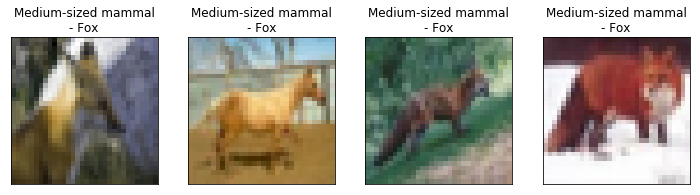

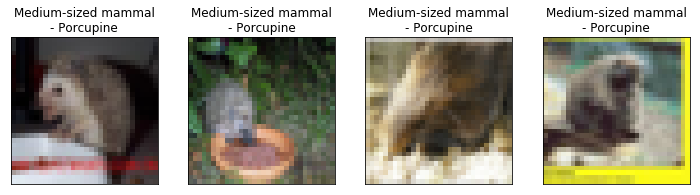

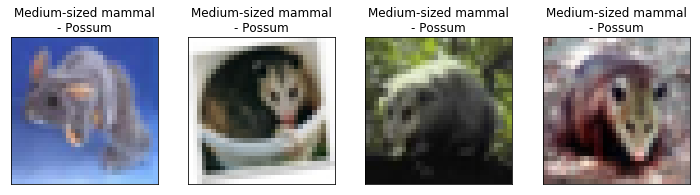

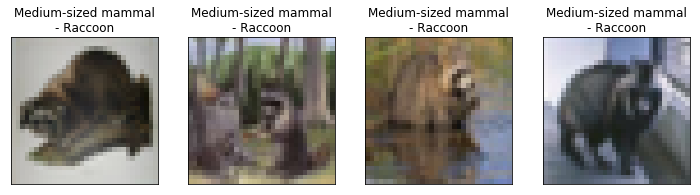

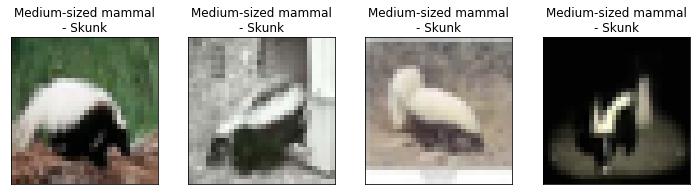

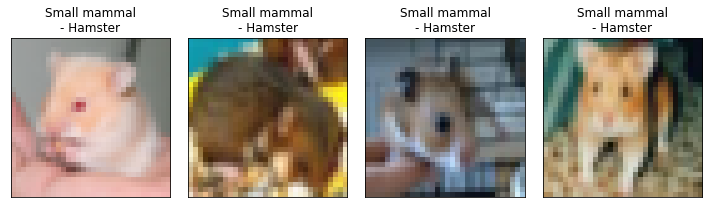

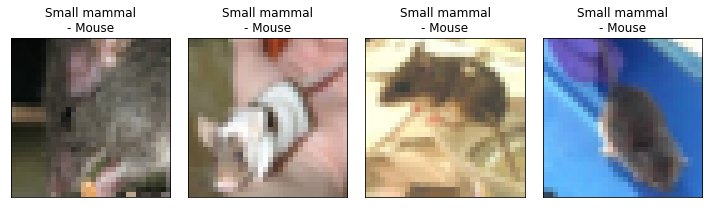

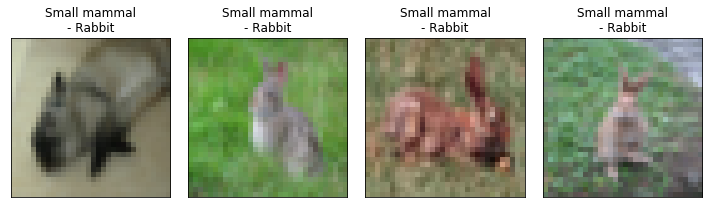

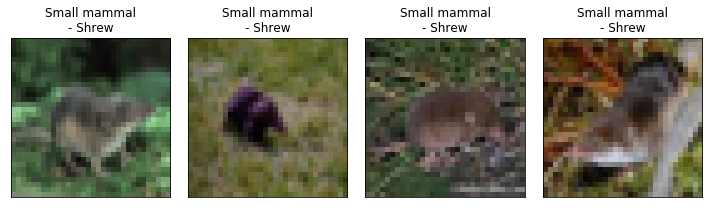

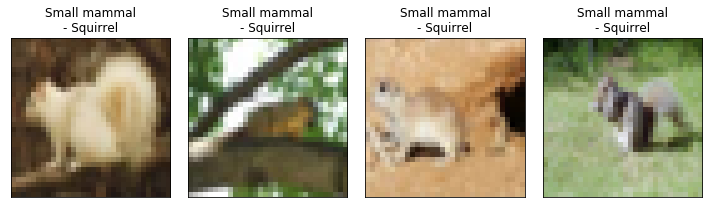

In [0]:
# Use the above function to plot 4 random images from each sub-class
indices = [np.random.choice(range(len(x1)),replace=False) for i in range(4)]; cifar_grid0(x1,y1,34,indices,4)
indices = [np.random.choice(range(len(x2)),replace=False) for i in range(4)]; cifar_grid0(x2,y2,63,indices,4)
indices = [np.random.choice(range(len(x3)),replace=False) for i in range(4)]; cifar_grid0(x3,y3,64,indices,4)
indices = [np.random.choice(range(len(x4)),replace=False) for i in range(4)]; cifar_grid0(x4,y4,66,indices,4)
indices = [np.random.choice(range(len(x5)),replace=False) for i in range(4)]; cifar_grid0(x5,y5,75,indices,4)
indices = [np.random.choice(range(len(x6)),replace=False) for i in range(4)]; cifar_grid0(x6,y6,36,indices,4)
indices = [np.random.choice(range(len(x7)),replace=False) for i in range(4)]; cifar_grid0(x7,y7,50,indices,4)
indices = [np.random.choice(range(len(x8)),replace=False) for i in range(4)]; cifar_grid0(x8,y8,65,indices,4)
indices = [np.random.choice(range(len(x9)),replace=False) for i in range(4)]; cifar_grid0(x9,y9,74,indices,4)
indices = [np.random.choice(range(len(x10)),replace=False) for i in range(4)]; cifar_grid0(x10,y10,80,indices,4)

In [0]:
# Reshape the values
x_train_1 = x_train.reshape(x_train.shape[0],3*32*32)
x_test_1 = x_test.reshape(x_test.shape[0],3*32*32)


In [0]:
#print out randomly selected images and their labels
def cifar_grid(X,Y,inds,n_col,predictions):  
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(15, 20))
  #count=0
  #l=list()
# align labels in the right order  #encode the target class
  clabels = ['small_mammals','medium_sized_mammal']
  #print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
     
      if i_inds < N:
        rgb = X[[i_data,...]]
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        #pred = clabels[np.argmax(predictions[i_data,...])]
        pred = clabels[predictions[i_data]]
        plt.imshow(img, interpolation='nearest')
        plt.title("actual: {}\n predict: {}".format(label,pred))
        #if label==pred:
        #  count+=1
        #  l.append(j*4+k)
  #print(count)
  #print(l)
         
  fig.set_tight_layout(True)
  
  # choose 36 img randomly
indices = [np.random.choice(range(len(x_test_1))) for i in range(36)]

In [0]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

## Logistic Regression

In [0]:
start = time.time()
lr = LogisticRegression()
lr.fit(x_train_1, y_train_bin)
lr_pred=lr.predict(x_test_1)
print ("Logistic Regression Accuracy: {}%".format(lr.score(x_test_1, y_test_bin)*100))
end = time.time()
print('{} seconds'.format(end - start))

Logistic Regression Accuracy: 59.599999999999994%
33.34806990623474 seconds


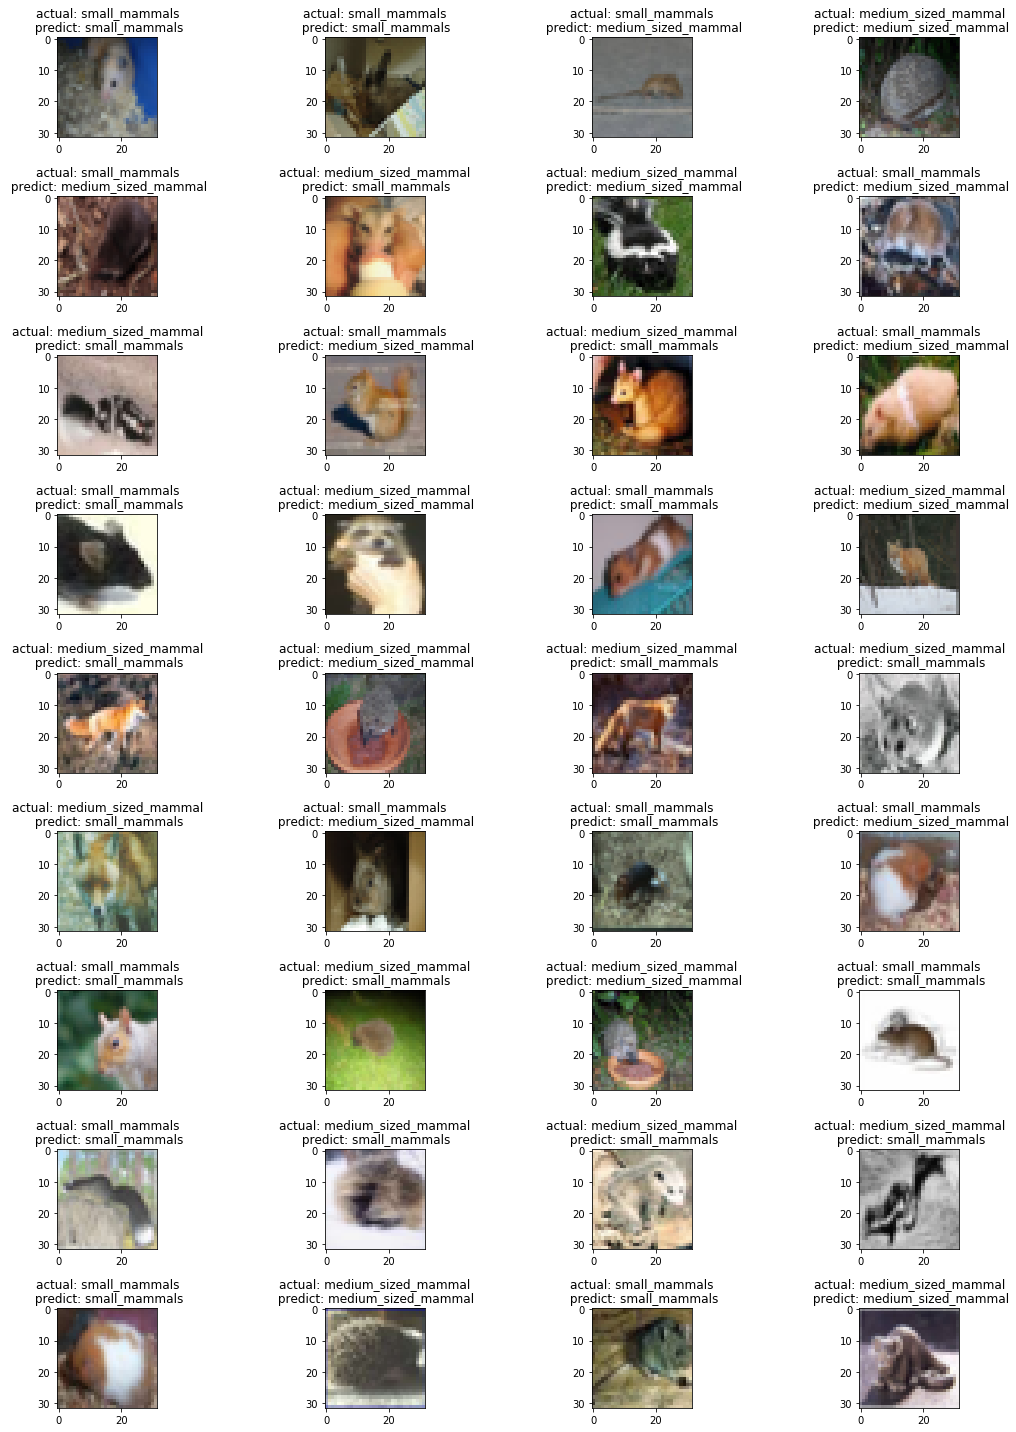

In [0]:
#cifar_grid(x_train,y_train_bin,indices,4,lr_pred)
cifar_grid(x_test_1, y_test_bin, indices,4,lr_pred)

In [0]:
print(confusion_matrix(y_test_bin, lr_pred, labels=None, sample_weight=None))

[[293 207]
 [197 303]]


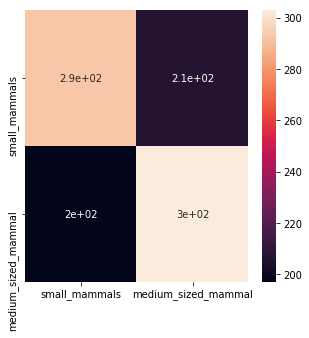

In [0]:
cm=confusion_matrix(y_test_bin, lr_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, lr_pred))

              precision    recall  f1-score   support

           0       0.60      0.59      0.59       500
           1       0.59      0.61      0.60       500

   micro avg       0.60      0.60      0.60      1000
   macro avg       0.60      0.60      0.60      1000
weighted avg       0.60      0.60      0.60      1000



## Bagging 

In [0]:
start = time.time()
bag = BaggingClassifier()  
bag.fit(x_train_1, y_train_bin)
bag_pred=bag.predict(x_test_1)
print ("Bagging Accuracy: {}%".format(bag.score(x_test_1, y_test_bin)*100))
end = time.time()
print('{} seconds'.format(end - start))

Bagging Accuracy: 62.9%
115.30391144752502 seconds


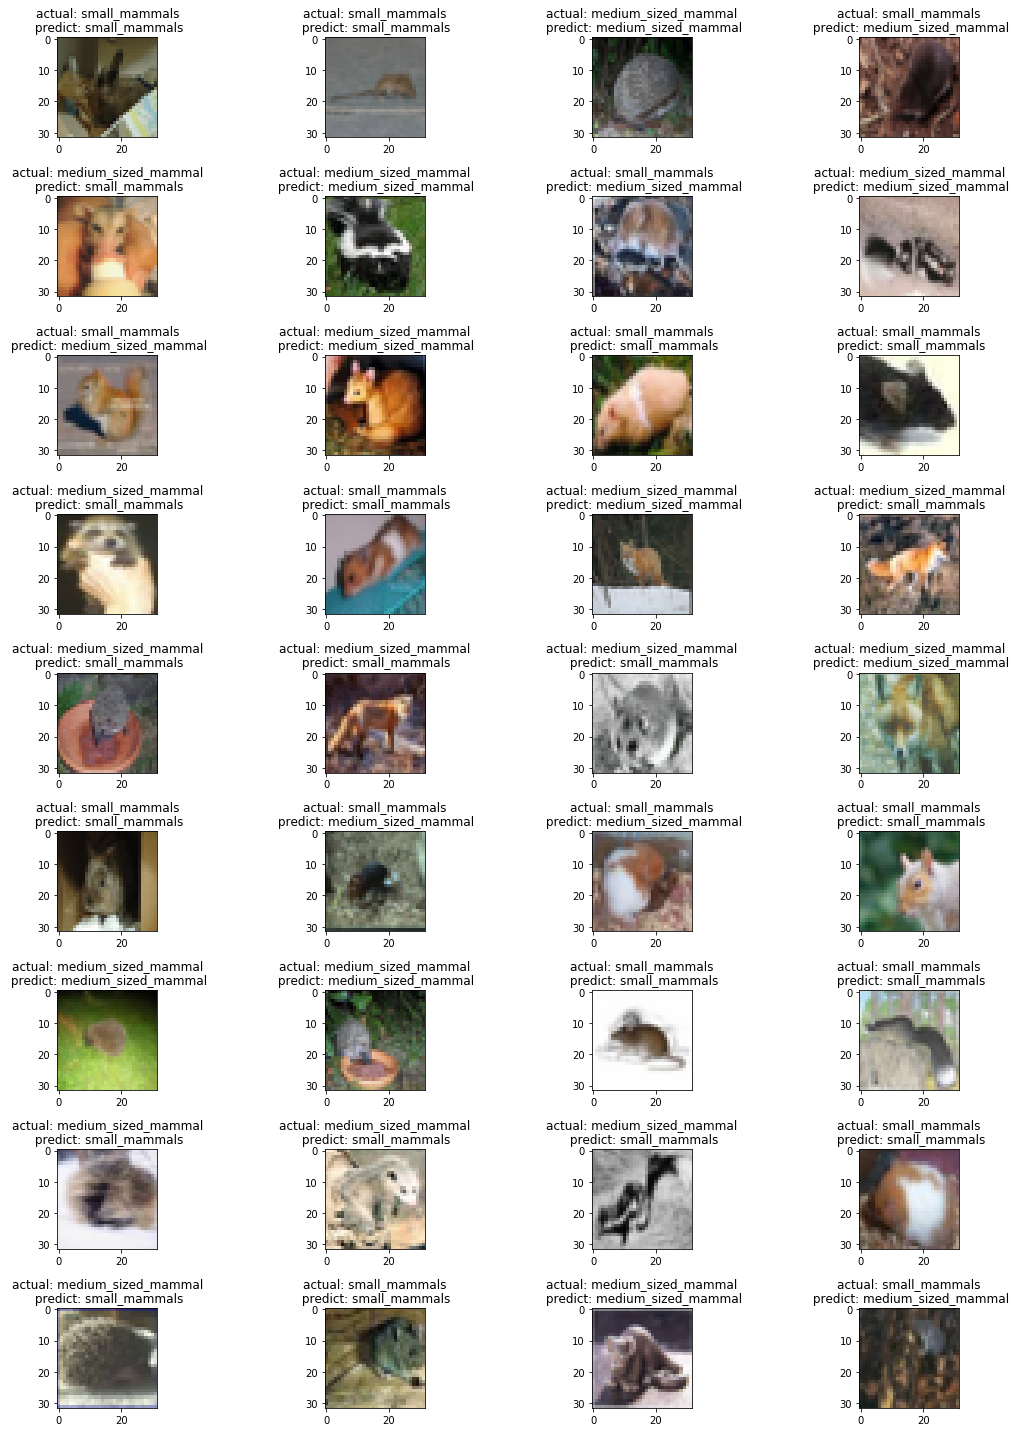

In [0]:
#cifar_grid(x_train,y_train_bin,indices,4,bag_pred)
cifar_grid(x_test_1, y_test_bin,indices,4,bag_pred)

In [0]:
print(confusion_matrix(y_test_bin, bag_pred, labels=None, sample_weight=None))

[[362 138]
 [233 267]]


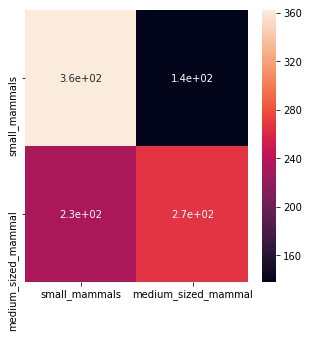

In [0]:
cm=confusion_matrix(y_test_bin, bag_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, bag_pred))

              precision    recall  f1-score   support

           0       0.61      0.72      0.66       500
           1       0.66      0.53      0.59       500

   micro avg       0.63      0.63      0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000



## SVM with kernel 'rbf' 

In [0]:
start = time.time()
rbf = SVC(kernel='rbf', C=5)
rbf.fit(x_train_1, y_train_bin)
rbf_pred=rbf.predict(x_test_1)
print ("SVM with rbf kernel Accuracy: {}%".format(rbf.score(x_test_1, y_test_bin)*100))
end = time.time()
print('{} seconds'.format(end - start))

SVM with rbf kernel Accuracy: 63.2%
157.40500020980835 seconds


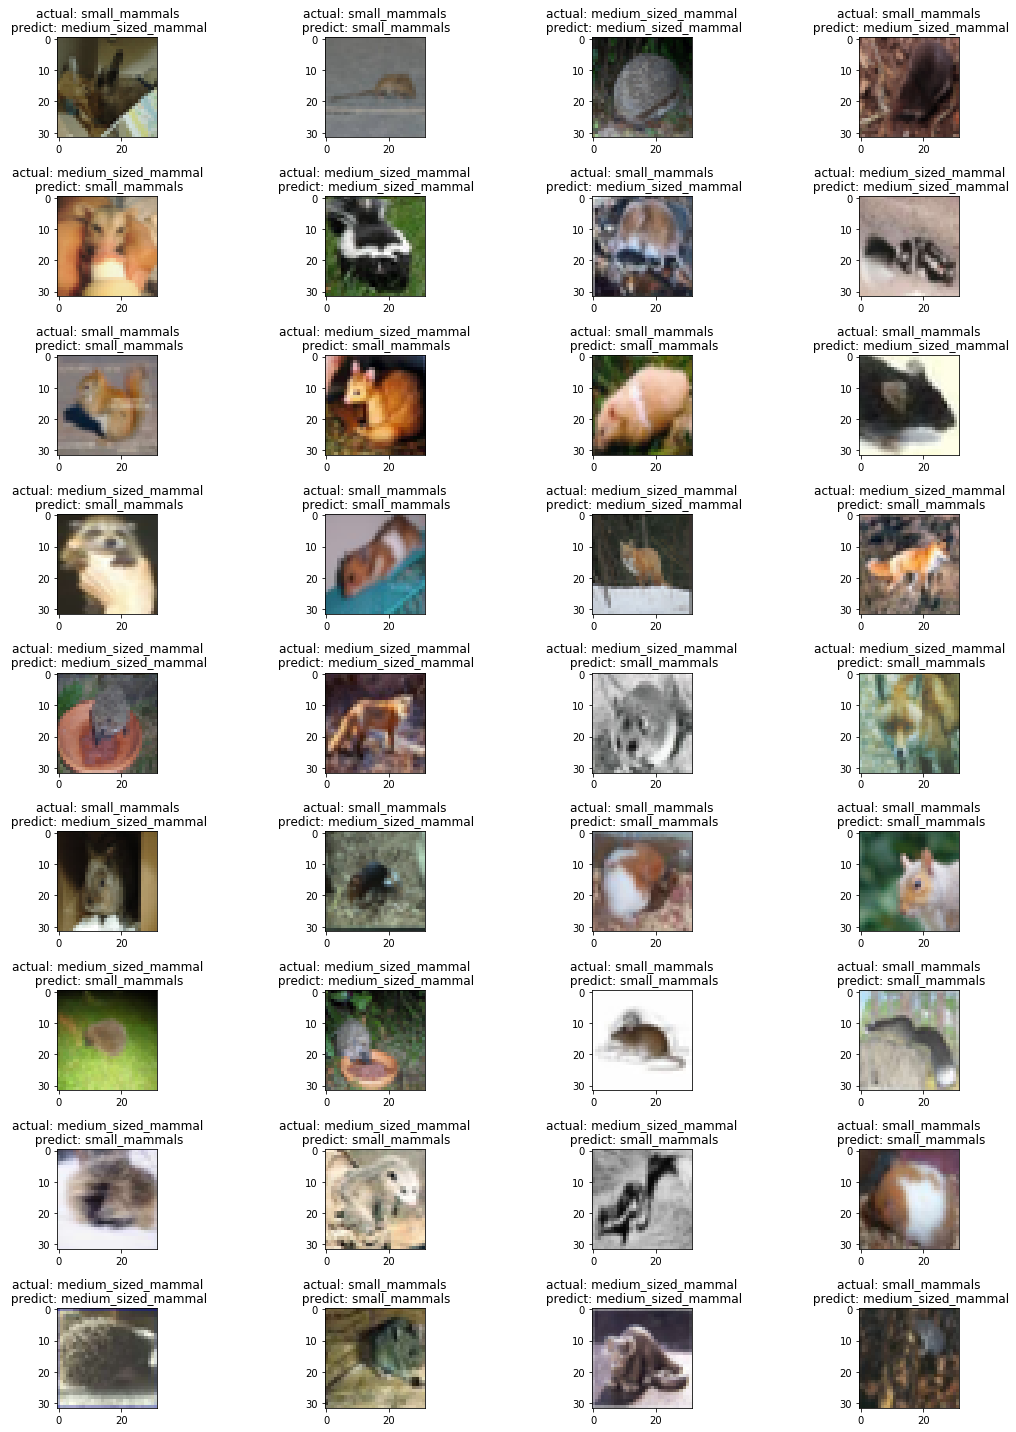

In [0]:
#cifar_grid(x_train,y_train_bin,indices,4,rbf_pred)
cifar_grid(x_test_1, y_test_bin,indices,4,rbf_pred)


In [0]:
print(confusion_matrix(y_test_bin, rbf_pred, labels=None, sample_weight=None))

[[316 184]
 [184 316]]


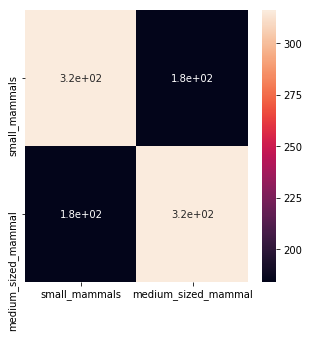

In [0]:
cm=confusion_matrix(y_test_bin, rbf_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, rbf_pred))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       500
           1       0.63      0.63      0.63       500

   micro avg       0.63      0.63      0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000



In [0]:
tuned_parameters = {'kernel': ['rbf'],
                     'C': [1,10]}

In [0]:
%%time
rbf_clf = GridSearchCV(SVC(), tuned_parameters, cv=5, verbose=0)
rbf_clf.fit(x_train_1, y_train_bin)

CPU times: user 29min 13s, sys: 447 ms, total: 29min 13s
Wall time: 29min 13s


In [0]:
print("Best parameters set found on development set:")
print()
print(rbf_clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = rbf_clf.cv_results_['mean_test_score']
stds = rbf_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rbf_clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

In [0]:
print ('prediction score on testing data with the best estimator: %.2f%%' % (rbf_clf.best_estimator_.score(x_test_1,y_test_bin)*100))

In [0]:
rbf_best_pred=rbf_clf.predict(x_test_1)

In [0]:
cifar_grid(x_test_1, y_test_bin, indices,4,rbf_best_pred)

In [0]:
cm=confusion_matrix(y_test_bin, rbf_best_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, rbf_best_pred))

## SVM with kernel 'sigmoid' 

In [0]:
start = time.time()
sig = SVC(kernel='sigmoid', C=5)
sig.fit(x_train_1, y_train_bin)
sig_pred=sig.predict(x_test_1)
print ("SVM with sigmoid kernel Accuracy: {}%".format(sig.score(x_test_1, y_test_bin)*100))
end = time.time()
print('{} seconds'.format(end - start))

SVM with sigmoid kernel Accuracy: 55.1%
125.4113097190857 seconds


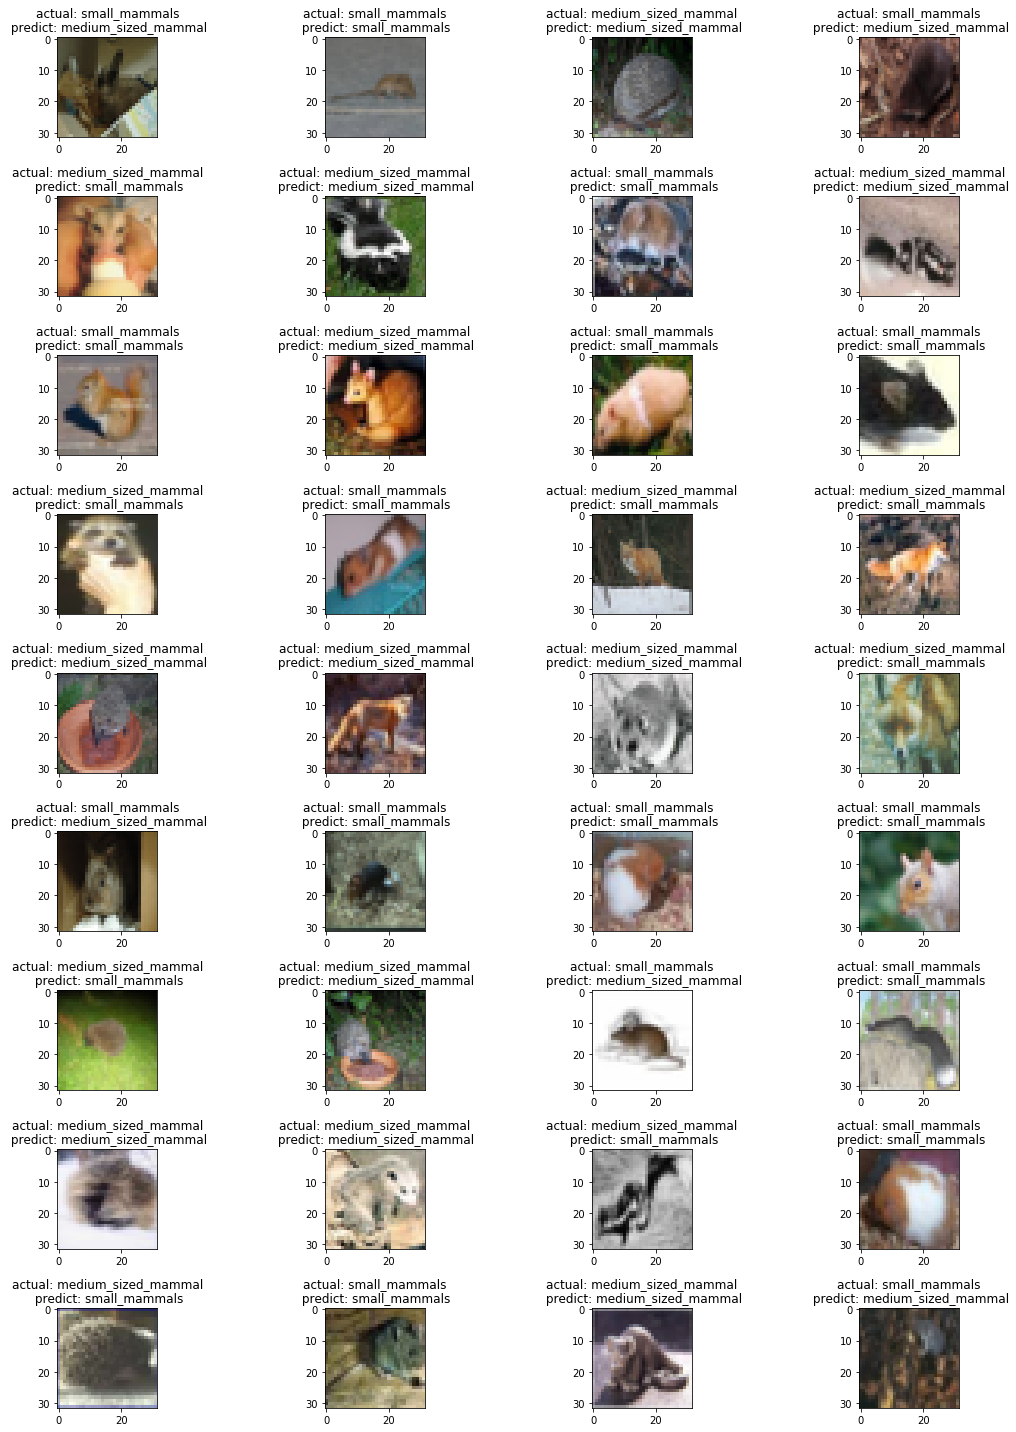

In [0]:
#cifar_grid(x_train,y_train_bin,indices,4,sig_pred)
cifar_grid(x_test_1, y_test_bin,indices,4,sig_pred)

In [0]:
print(confusion_matrix(y_test_bin, sig_pred, labels=None, sample_weight=None))

[[291 209]
 [240 260]]


In [0]:
print(classification_report(y_test_bin, sig_pred))

              precision    recall  f1-score   support

           0       0.55      0.58      0.56       500
           1       0.55      0.52      0.54       500

   micro avg       0.55      0.55      0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



## SVM with 'llinear' kernel

In [0]:
start = time.time()
clf = SVC(kernel='linear', C=5)
clf.fit(x_train_1, y_train_bin)
clf_pred=clf.predict(x_test_1)
print ("SVM with linear kernel Accuracy: {}%".format(clf.score(x_test_1, y_test_bin)*100))
end = time.time()
print('{} seconds'.format(end - start))

SVM with linear kernel Accuracy: 58.5%
337.63181471824646 seconds


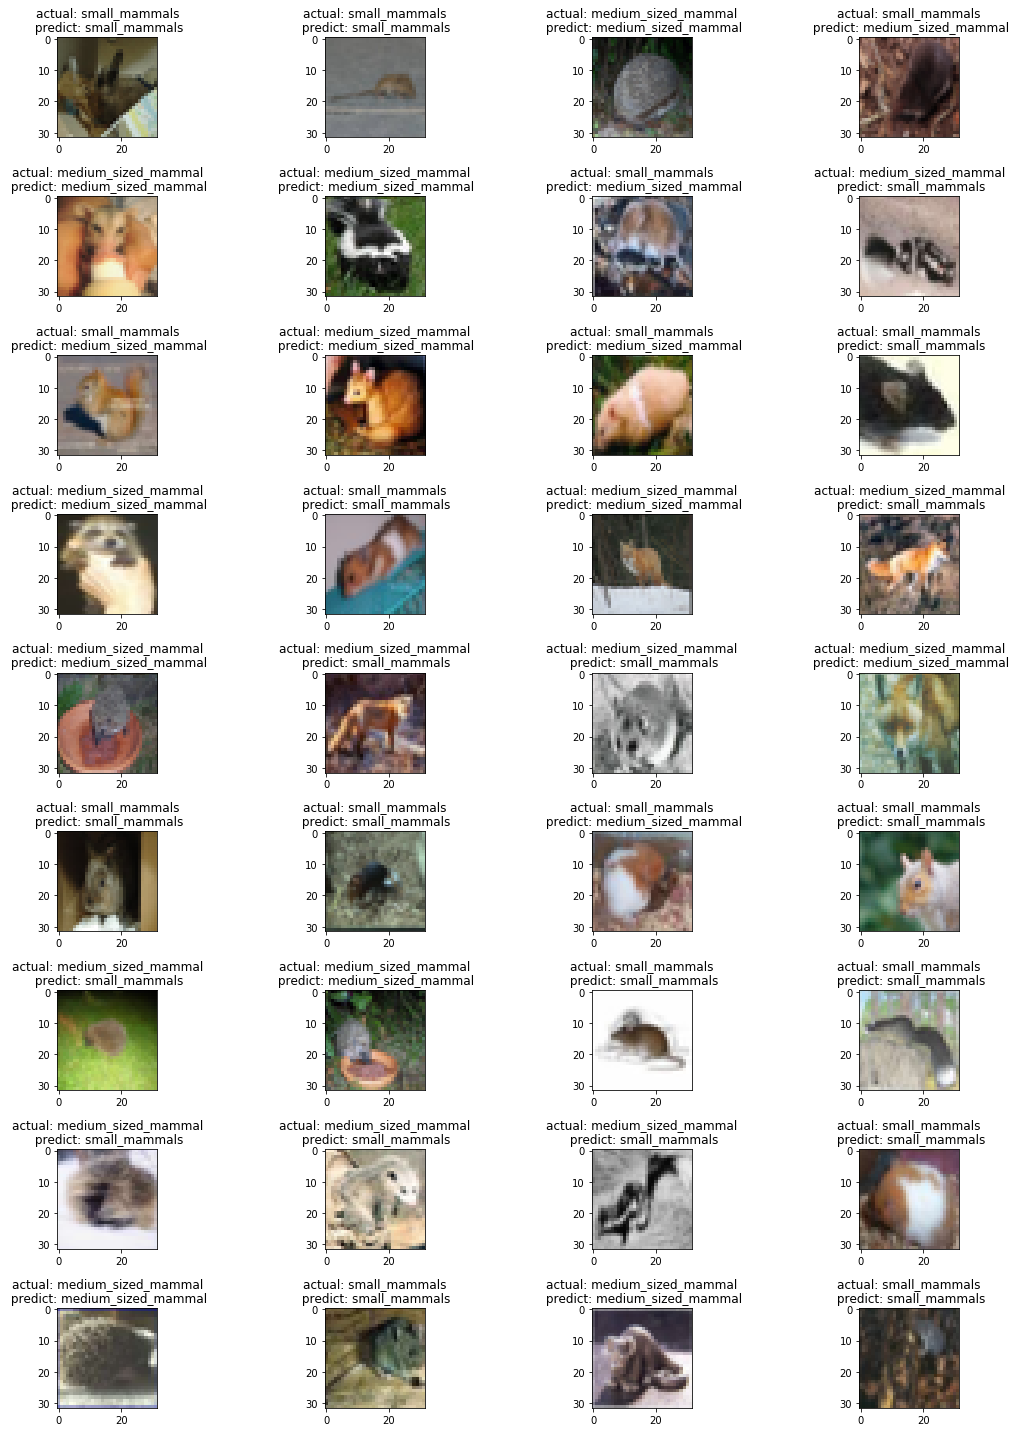

In [0]:
cifar_grid(x_test_1, y_test_bin,indices,4,clf_pred)

In [0]:
print(confusion_matrix(y_test_bin, clf_pred, labels=None, sample_weight=None))

[[294 206]
 [209 291]]


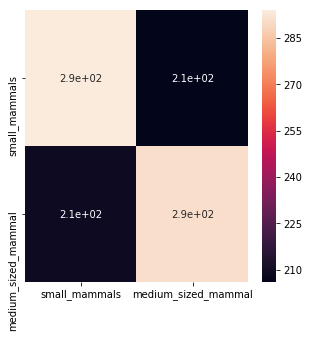

In [0]:
cm=confusion_matrix(y_test_bin, clf_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, clf_pred))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59       500
           1       0.59      0.58      0.58       500

   micro avg       0.58      0.58      0.58      1000
   macro avg       0.59      0.58      0.58      1000
weighted avg       0.59      0.58      0.58      1000



## SVM with the "poly" kernel 

In [0]:
start = time.time()
clf_l = SVC(kernel='linear', C=5)
clf_l.fit(x_train_1, y_train_bin)
clf_l_pred=clf_l.predict(x_test_1)
print ("SVM with sigmoid kernel Accuracy: {}%".format(clf_l.score(x_test_1, y_test_bin)*100))
end = time.time()
print('{} seconds'.format(end - start))

SVM with sigmoid kernel Accuracy: 58.5%
336.5840380191803 seconds


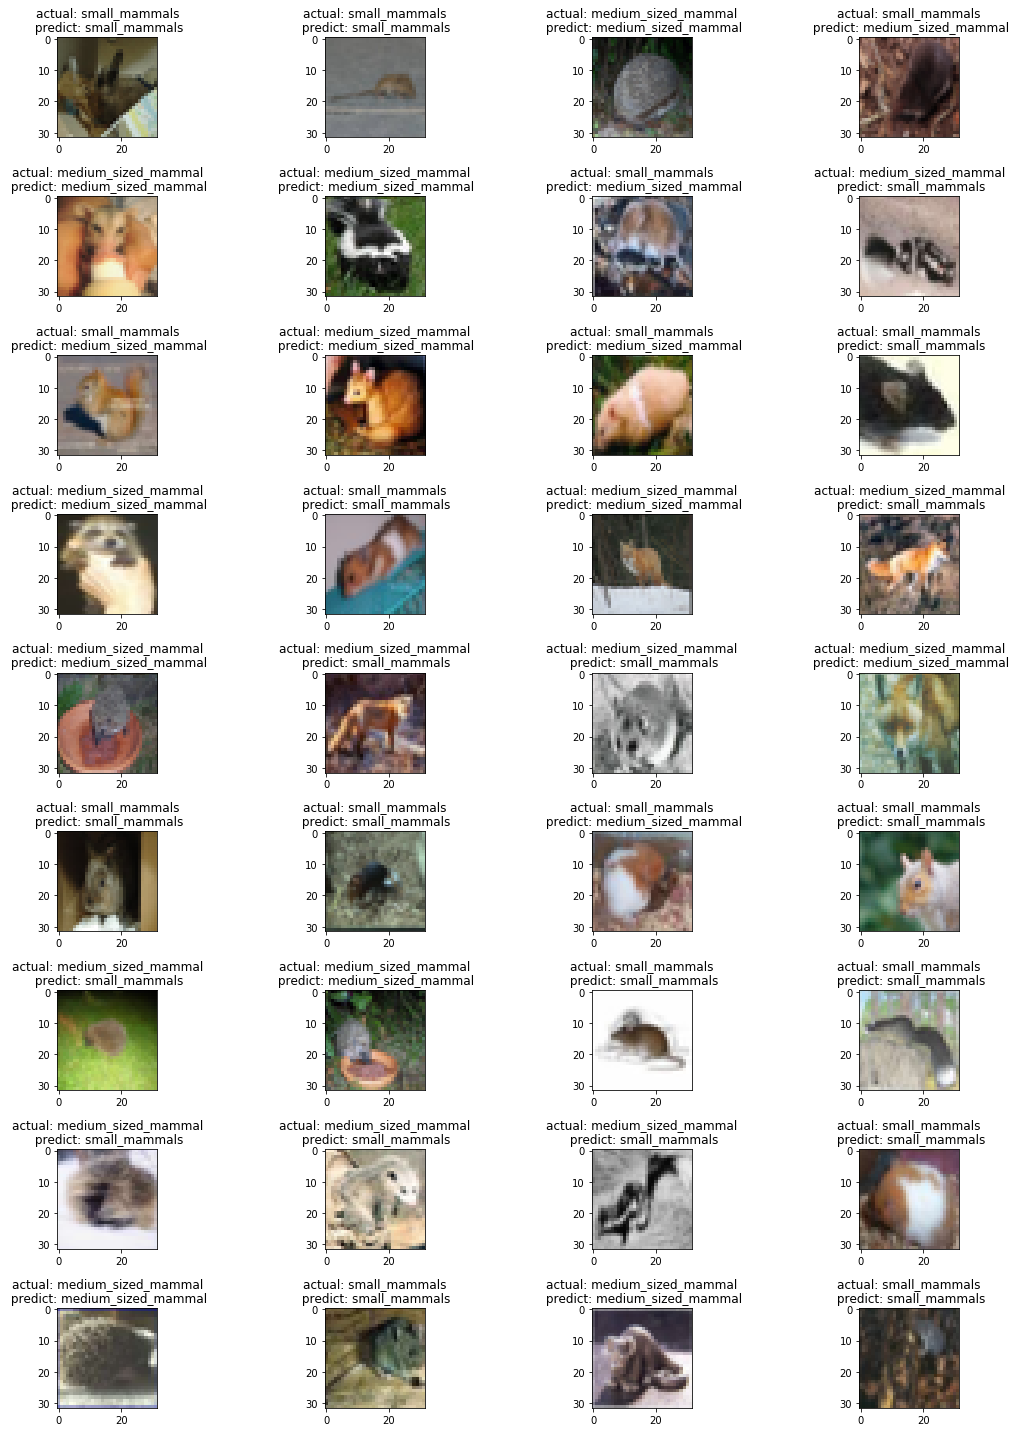

In [0]:
cifar_grid(x_test_1, y_test_bin,indices,4,clf_l_pred)

In [0]:
print(confusion_matrix(y_test_bin, clf_l_pred, labels=None, sample_weight=None))

[[294 206]
 [209 291]]


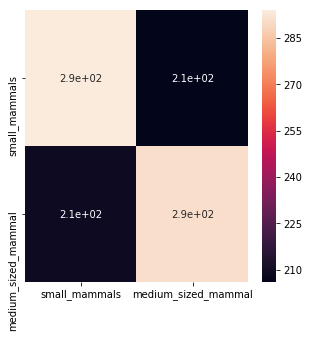

In [0]:
cm=confusion_matrix(y_test_bin, clf_l_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, clf_l_pred))

              precision    recall  f1-score   support

           0       0.58      0.59      0.59       500
           1       0.59      0.58      0.58       500

   micro avg       0.58      0.58      0.58      1000
   macro avg       0.59      0.58      0.58      1000
weighted avg       0.59      0.58      0.58      1000



## KNN

In [0]:
start = time.time()
knn = KNeighborsClassifier()
knn.fit(x_train_1, y_train_bin)
knn_pred=knn.predict(x_test_1)
print ("KNN Accuracy: {}%".format(knn.score(x_test_1, y_test_bin)*100))
end = time.time()
print('{} seconds'.format(end - start))

KNN Accuracy: 61.3%
75.46256732940674 seconds


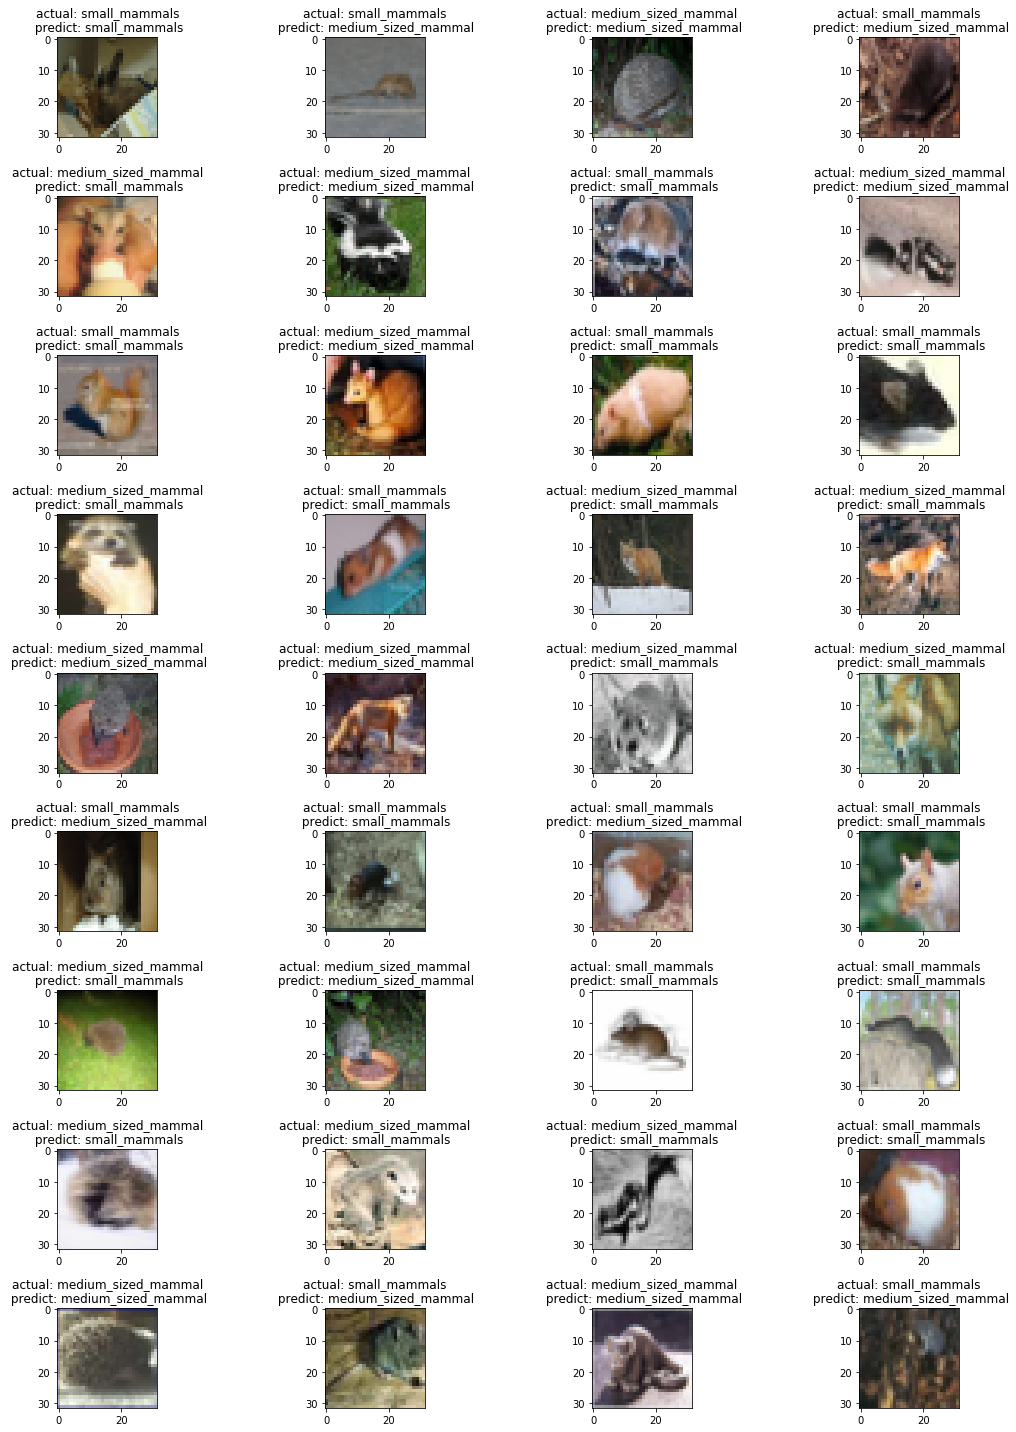

In [0]:
#cifar_grid(x_train,y_train_bin,indices,4,knn_pred)
cifar_grid(x_test_1, y_test_bin,indices,4,knn_pred)

In [0]:
print(confusion_matrix(y_test_bin, knn_pred, labels=None, sample_weight=None))

[[362 138]
 [249 251]]


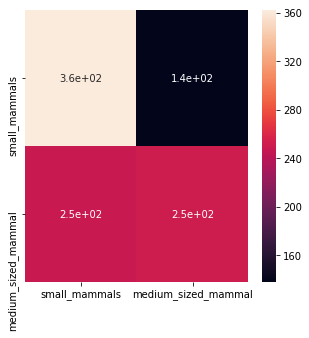

In [0]:
cm=confusion_matrix(y_test_bin, knn_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, knn_pred))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65       500
           1       0.65      0.50      0.56       500

   micro avg       0.61      0.61      0.61      1000
   macro avg       0.62      0.61      0.61      1000
weighted avg       0.62      0.61      0.61      1000



## Gradient Boosting Classifer 

In [0]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
start = time.time()
Gradient = GradientBoostingClassifier()
Gradient.fit(x_train_1, y_train_bin)
Gradient_pred=Gradient.predict(x_test_1)
print ("GradientBoostingclassifier: {}%".format(Gradient.score(x_test_1, y_test_bin)*100))
end = time.time()
print(end - start)

GradientBoostingclassifier: 65.8%
141.86757826805115


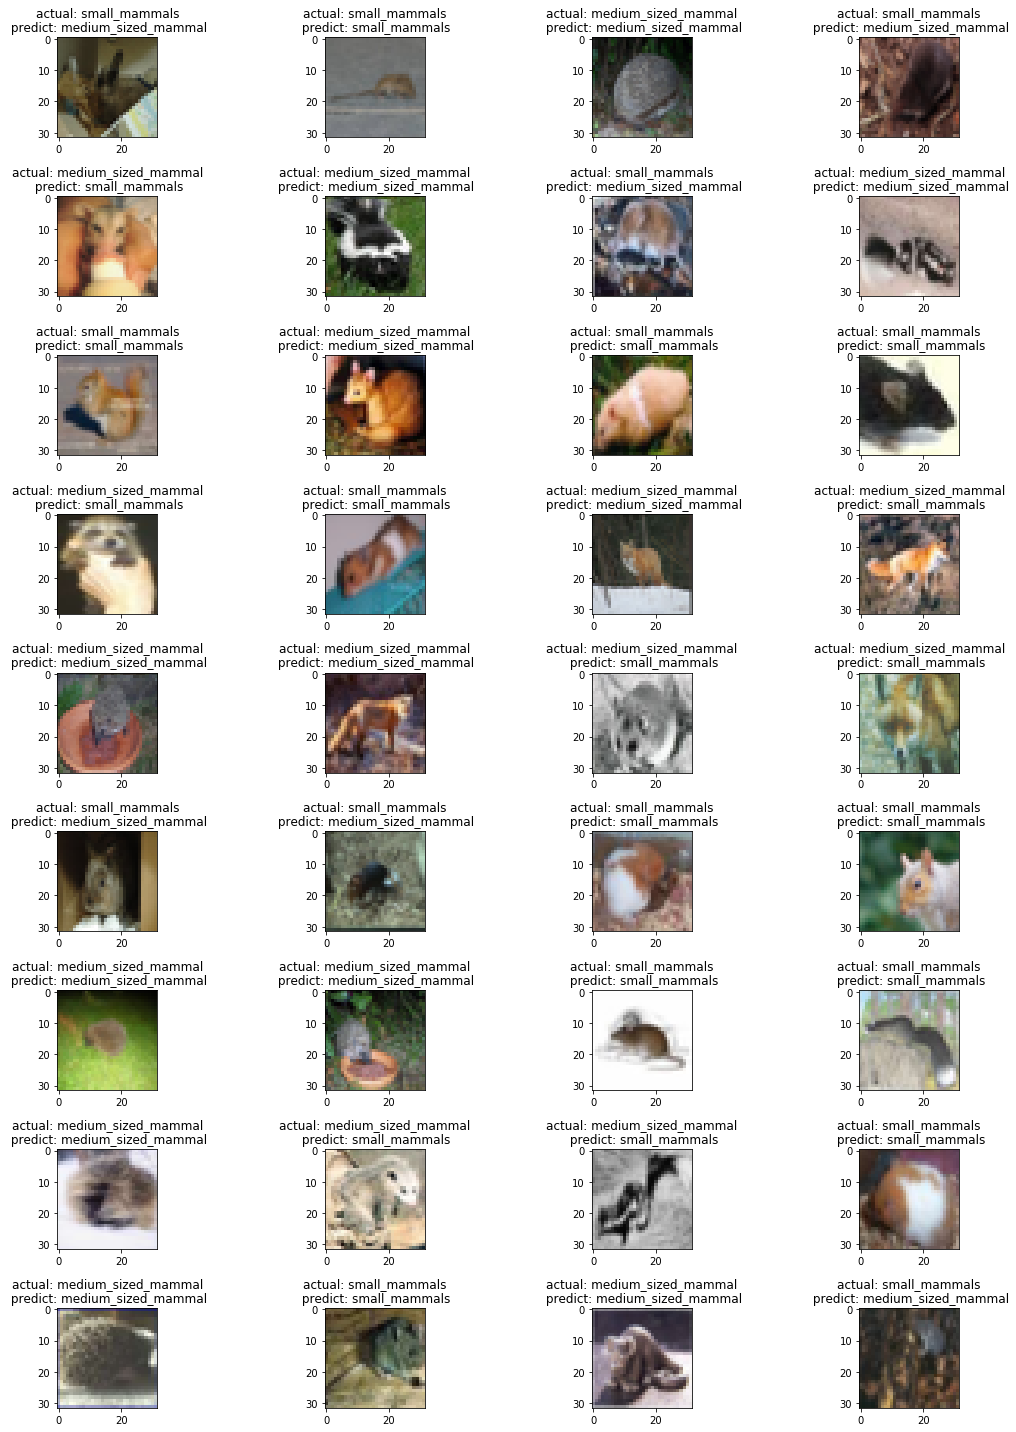

In [0]:

cifar_grid(x_test_1, y_test_bin,indices,4,Gradient_pred)

In [0]:
print(confusion_matrix(y_test_bin, Gradient_pred, labels=None, sample_weight=None))

[[349 151]
 [191 309]]


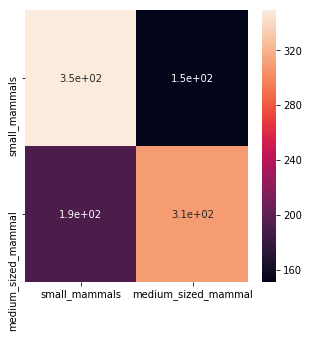

In [0]:
cm=confusion_matrix(y_test_bin, Gradient_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, Gradient_pred))

              precision    recall  f1-score   support

           0       0.65      0.70      0.67       500
           1       0.67      0.62      0.64       500

   micro avg       0.66      0.66      0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.66      0.66      0.66      1000



## Ada boosting

In [0]:
start = time.time()
Ada = AdaBoostClassifier()
Ada.fit(x_train_1, y_train_bin)
Ada_pred=Ada.predict(x_test_1)
print ("Adaboostclassifier: {}%".format(Ada.score(x_test_1, y_test_bin)*100))
end = time.time()
print(end - start)

Adaboostclassifier: 58.3%
63.460001945495605


In [0]:
print(confusion_matrix(y_test_bin, Ada_pred, labels=None, sample_weight=None))

[[293 207]
 [210 290]]


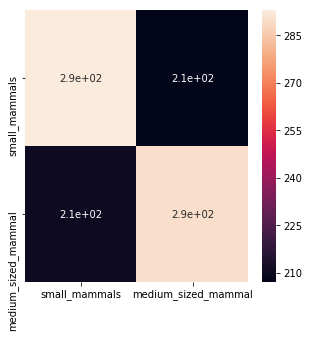

In [0]:
cm=confusion_matrix(y_test_bin, Ada_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

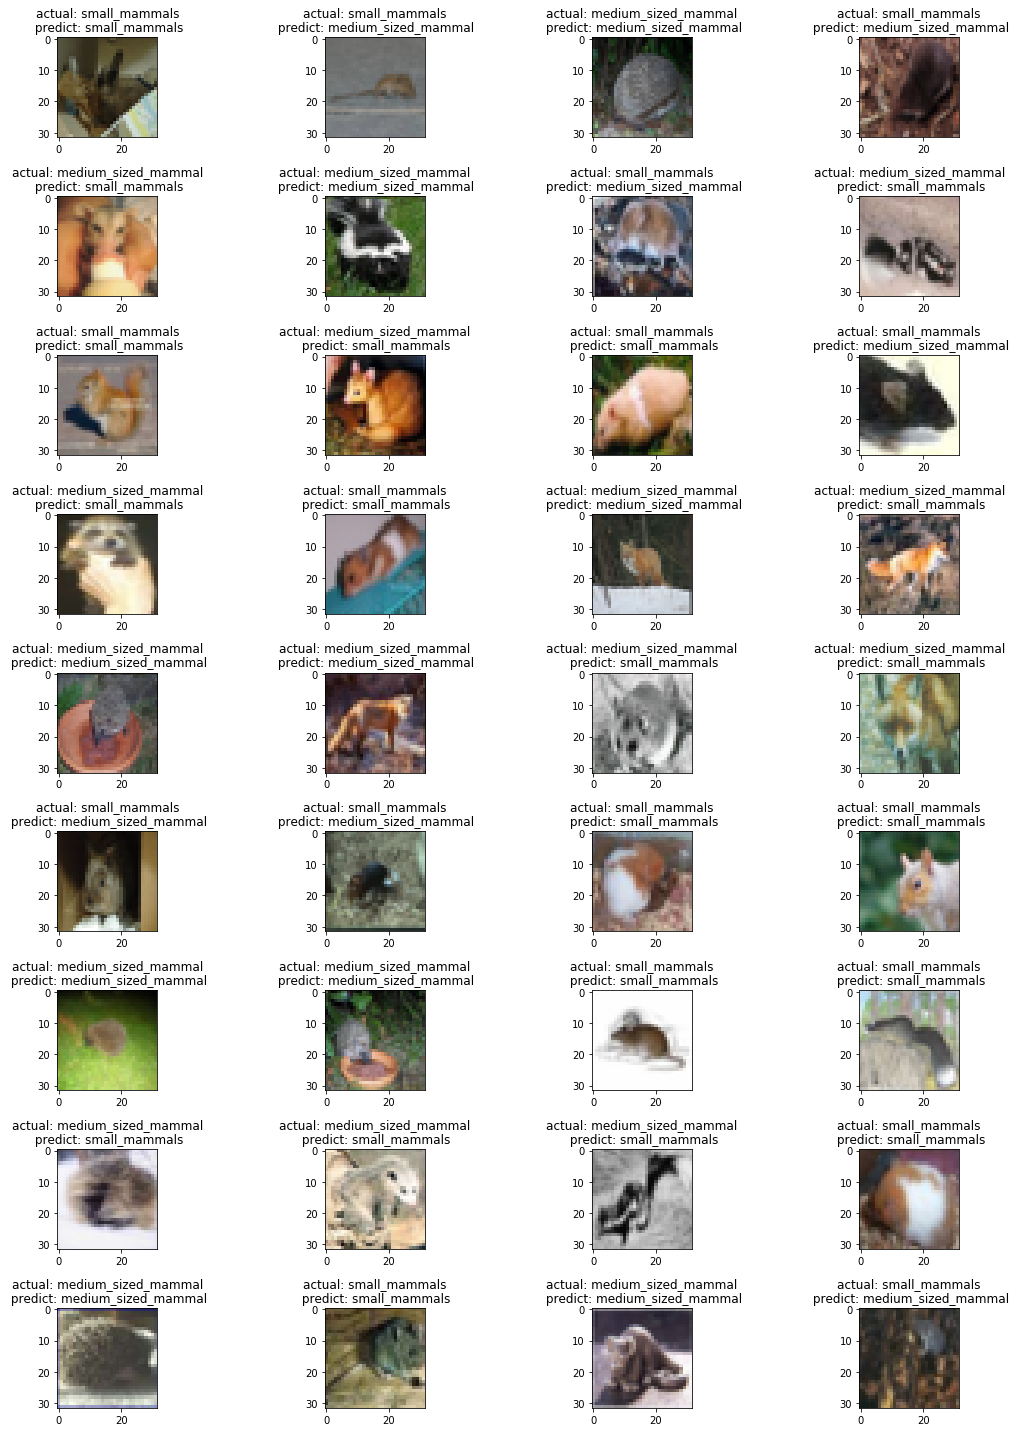

In [0]:
cifar_grid(x_test_1, y_test_bin,indices,4,Ada_pred)

In [0]:
print(classification_report(y_test_bin, Ada_pred))

              precision    recall  f1-score   support

           0       0.58      0.59      0.58       500
           1       0.58      0.58      0.58       500

   micro avg       0.58      0.58      0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000



## Decision Tree 

In [0]:
start = time.time()
tree = DecisionTreeClassifier()
tree.fit(x_train_1, y_train_bin)
tree_pred = tree.predict(x_test_1)
print ("DecisionTree Accuracy: {}%".format(tree.score(x_test_1, y_test_bin)*100))
end = time.time()
print(end - start)

DecisionTree Accuracy: 57.49999999999999%
15.552714824676514


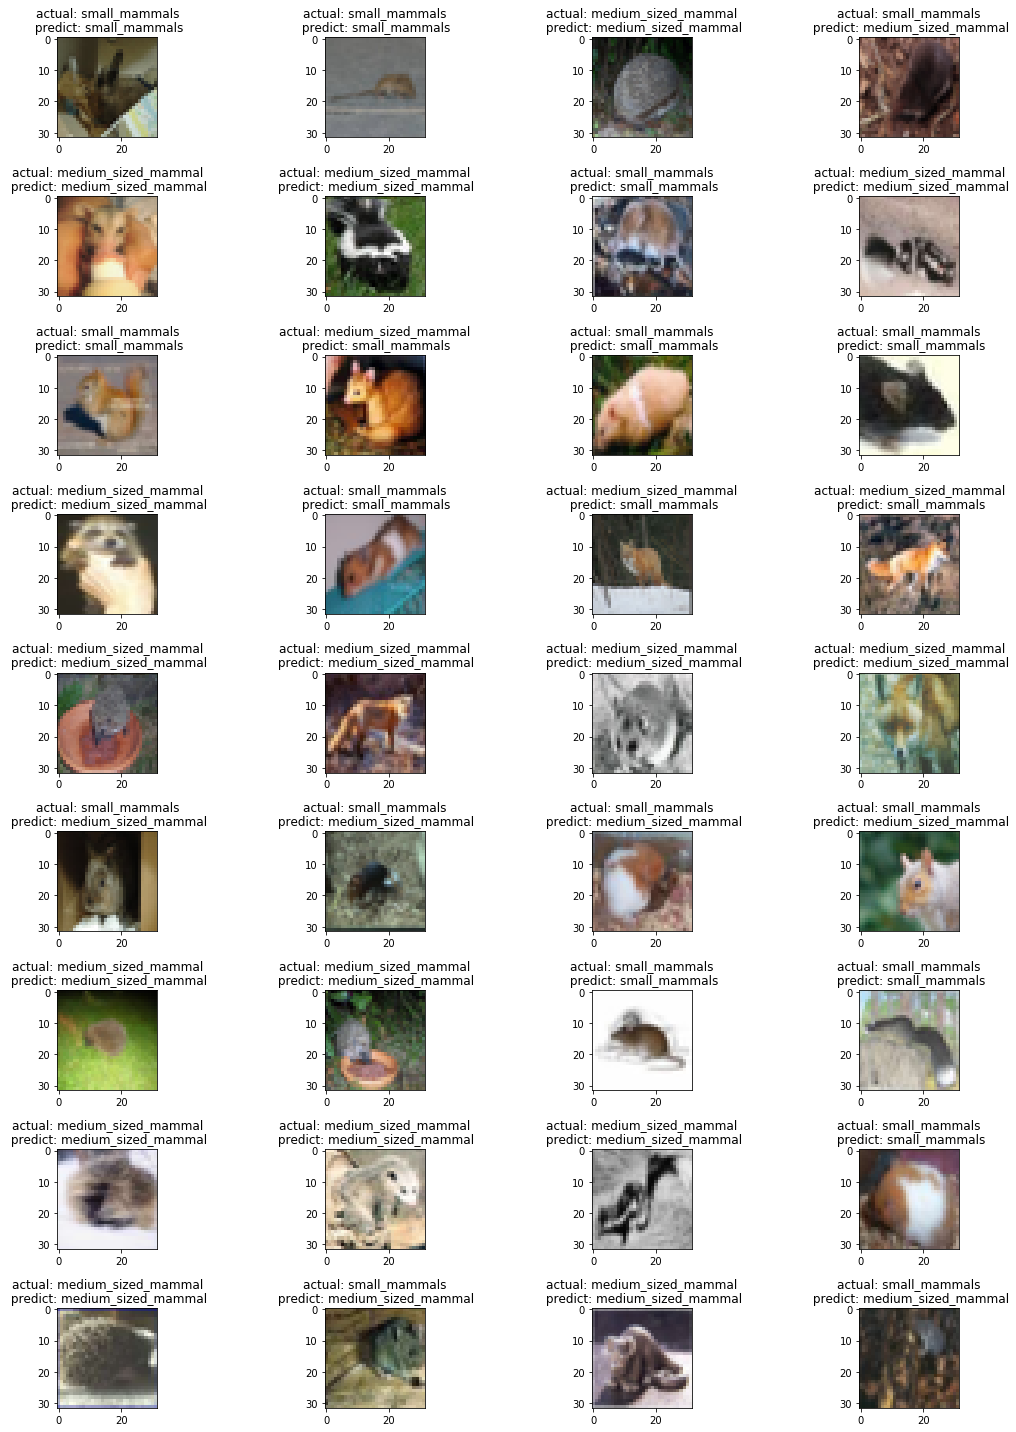

In [0]:
cifar_grid(x_test_1, y_test_bin,indices,4,tree_pred)

In [0]:
print(confusion_matrix(y_test_bin, tree_pred, labels=None, sample_weight=None))

[[296 204]
 [221 279]]


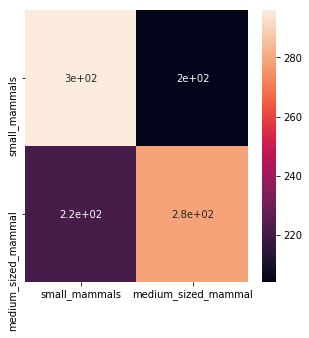

In [0]:
cm=confusion_matrix(y_test_bin,  tree_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, tree_pred))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       500
           1       0.58      0.56      0.57       500

   micro avg       0.57      0.57      0.57      1000
   macro avg       0.58      0.57      0.57      1000
weighted avg       0.58      0.57      0.57      1000



## Extra Decision Tree 

In [0]:
#using the default parameter
start = time.time()
Extratree = ExtraTreesClassifier()
Extratree.fit(x_train_1, y_train_bin)
Extratree_pred = Extratree.predict(x_test_1)
print ("ExtraTree Accuracy: {}%".format(Extratree.score(x_test_1, y_test_bin)*100))
end = time.time()
print(end - start)

ExtraTree Accuracy: 61.8%
0.8412554264068604


In [0]:
# train the model by tuning the parameters using gridsearch, cross_validation by split the trainning data into 5
tuned_parameters = {'n_estimators': [10,50,100,500,1000], 'max_depth': [5, 10,20,30]}


In [0]:
%%time
Extratree = GridSearchCV(ExtraTreesClassifier(), tuned_parameters, cv=5, verbose=0)
Extratree.fit(x_train_1, y_train_bin)


CPU times: user 29min 29s, sys: 995 ms, total: 29min 30s
Wall time: 29min 31s


In [0]:
print("Best parameters set found on development set:")
print()
print(Extratree.best_params_)
print()
print("Grid scores on development set:")
print()
means = Extratree.cv_results_['mean_test_score']
stds = Extratree.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, Extratree.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    

Best parameters set found on development set:

{'max_depth': 30, 'n_estimators': 500}

Grid scores on development set:

0.632 (+/-0.025) for {'max_depth': 5, 'n_estimators': 10}
0.642 (+/-0.012) for {'max_depth': 5, 'n_estimators': 50}
0.642 (+/-0.012) for {'max_depth': 5, 'n_estimators': 100}
0.639 (+/-0.011) for {'max_depth': 5, 'n_estimators': 500}
0.643 (+/-0.006) for {'max_depth': 5, 'n_estimators': 1000}
0.630 (+/-0.026) for {'max_depth': 10, 'n_estimators': 10}
0.649 (+/-0.016) for {'max_depth': 10, 'n_estimators': 50}
0.658 (+/-0.018) for {'max_depth': 10, 'n_estimators': 100}
0.661 (+/-0.010) for {'max_depth': 10, 'n_estimators': 500}
0.660 (+/-0.011) for {'max_depth': 10, 'n_estimators': 1000}
0.608 (+/-0.031) for {'max_depth': 20, 'n_estimators': 10}
0.650 (+/-0.017) for {'max_depth': 20, 'n_estimators': 50}
0.666 (+/-0.009) for {'max_depth': 20, 'n_estimators': 100}
0.677 (+/-0.023) for {'max_depth': 20, 'n_estimators': 500}
0.677 (+/-0.017) for {'max_depth': 20, 'n_estimat

In [0]:
print ('prediction score on testing data with the best estimator: %.2f%%' % (Extratree.best_estimator_.score(x_test_1,y_test_bin)*100))

prediction score on testing data with the best estimator: 67.00%


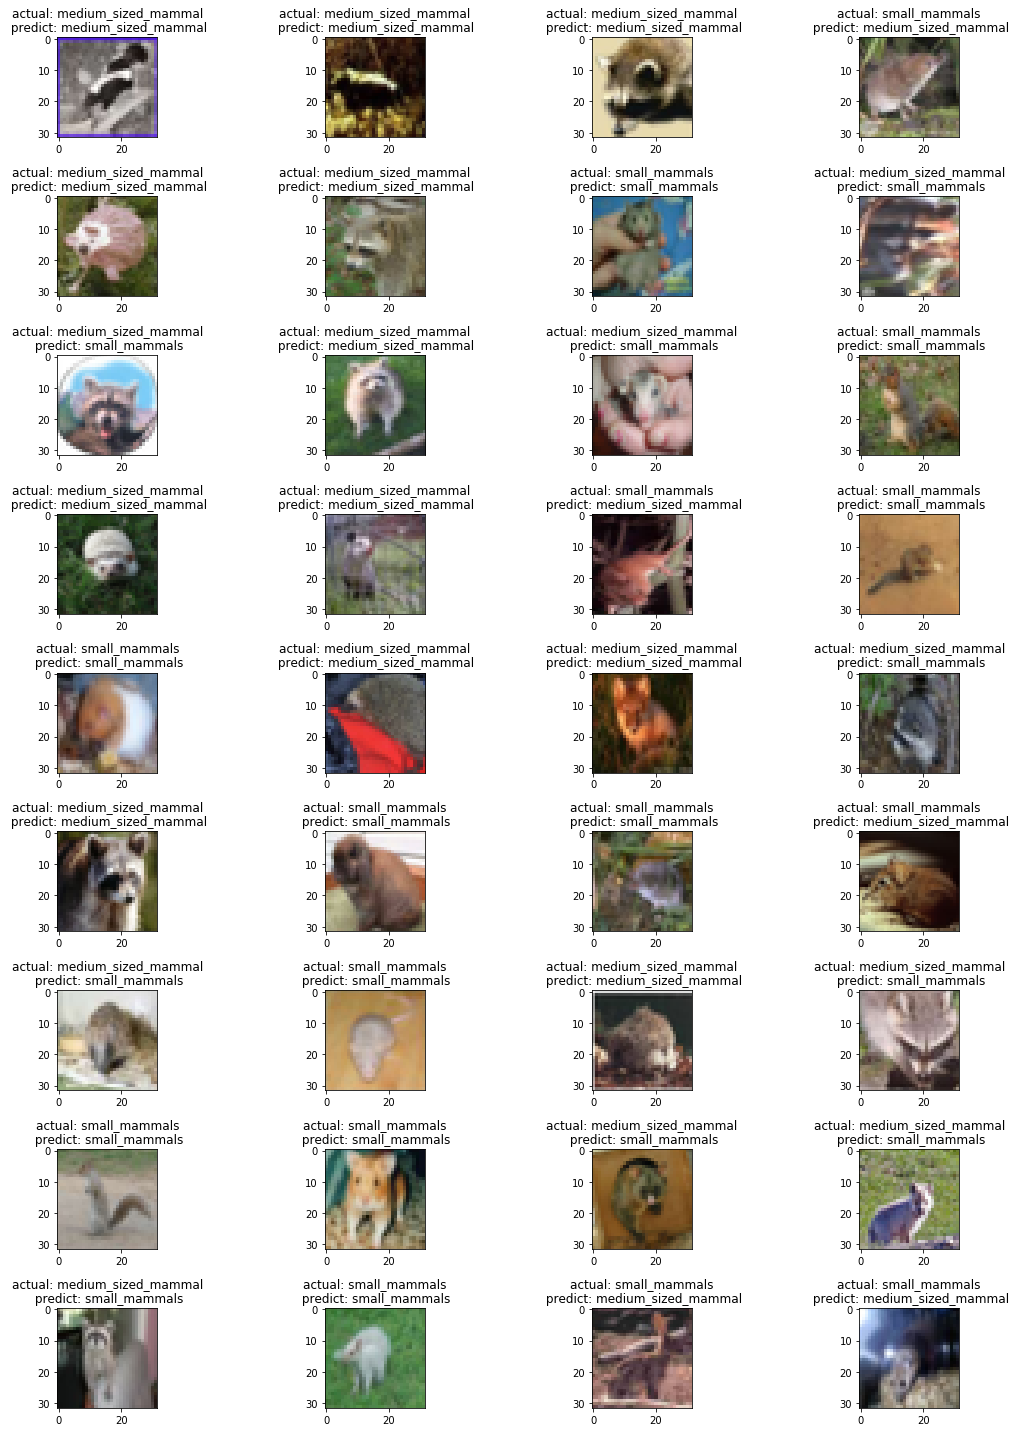

In [0]:
Extratree_pred = Extratree.predict(x_test_1)
cifar_grid(x_test_1, y_test_bin,indices,4,Extratree_pred)

In [0]:
print(confusion_matrix(y_test_bin, Extratree_pred, labels=None, sample_weight=None))

[[343 157]
 [173 327]]


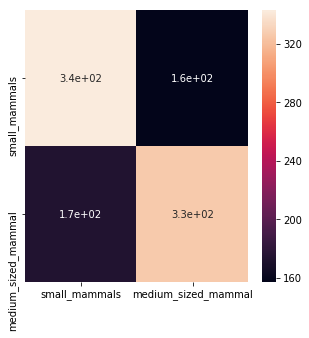

In [0]:
cm=confusion_matrix(y_test_bin,  Extratree_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, Extratree_pred))

              precision    recall  f1-score   support

           0       0.66      0.69      0.68       500
           1       0.68      0.65      0.66       500

   micro avg       0.67      0.67      0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000



## Random Forest 

In [0]:
start = time.time()
logit = RandomForestClassifier()
logit.fit(x_train_1, y_train_bin)
logit_pred=logit.predict(x_test_1)
print ("RandomForest Accuracy: {}%".format(logit.score(x_test_1, y_test_bin)*100))
end = time.time()
print(end - start)


RandomForest Accuracy: 62.6%
2.0312259197235107


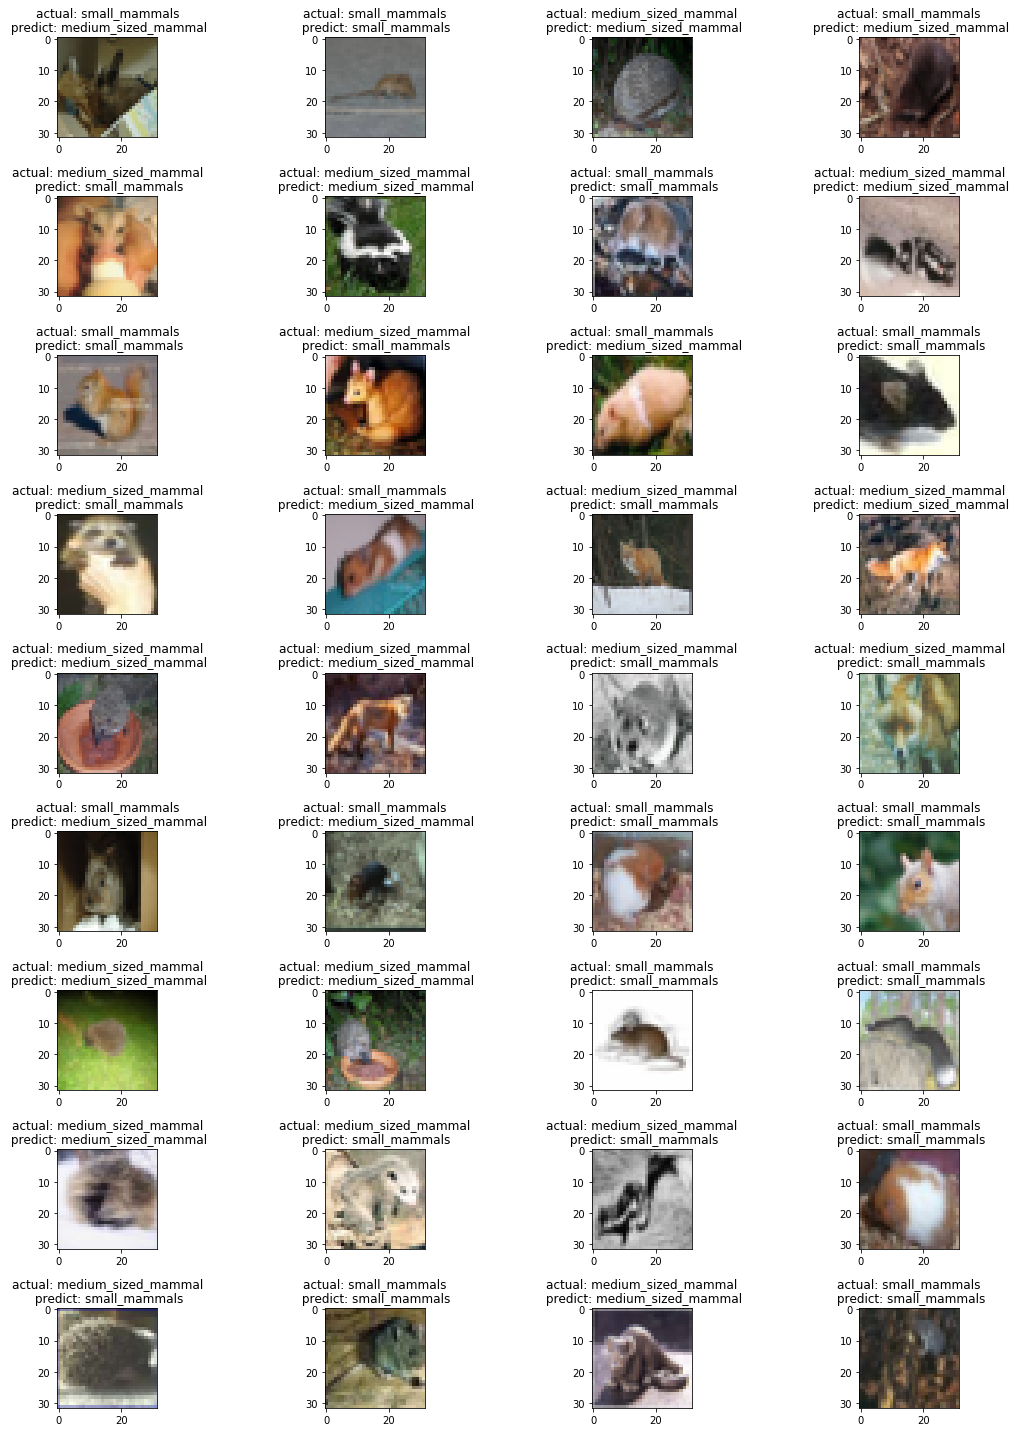

In [0]:
cifar_grid(x_test_1, y_test_bin,indices,4,logit_pred)

In [0]:
print(confusion_matrix(y_test_bin, logit_pred, labels=None, sample_weight=None))

[[361 139]
 [235 265]]


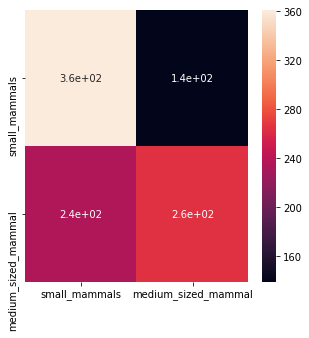

In [0]:
cm=confusion_matrix(y_test_bin, logit_pred, labels=[0,1], sample_weight=None)
plt.figure(figsize = (5,5))
df_cm = pd.DataFrame(cm, index = [i for i in ['small_mammals','medium_sized_mammal']],
                  columns = [i for i in ['small_mammals','medium_sized_mammal']])

ax=sns.heatmap(df_cm, annot=True)

In [0]:
print(classification_report(y_test_bin, logit_pred))

              precision    recall  f1-score   support

           0       0.61      0.72      0.66       500
           1       0.66      0.53      0.59       500

   micro avg       0.63      0.63      0.63      1000
   macro avg       0.63      0.63      0.62      1000
weighted avg       0.63      0.63      0.62      1000



# Neural Network (Fernanda)

In [0]:
#Label dictionary for our 10 target classes {34: 'fox', 63: 'porcupine', 64: 'possum', 66: 'raccoon', 75: 'skunk', 36: 'hamster', 50: 'mouse', 65: 'rabbit', 74: 'shrew', 80: 'squirrel'}

# check the data set.
print('x shape:', x.shape) #lists the images to be analyzed
print('multiple y shape:', y.shape)  #array with the 10 classes using the dictionary above
print('binary y shape:', y_bin.shape) # array with the super classes (medium or small mammals)

x shape: (6000, 3, 32, 32)
multiple y shape: (6000, 1)
binary y shape: (6000, 1)


In [0]:
# for keras application we need to transform one-hot encode our target (y_bin)

y_target = to_categorical(y_bin)
y_target.shape # now we have 1 column for medium and one for small mammals 

(6000, 2)

In [0]:
# the model also expects the samples to be rows in an array and each column to represent a pixel, so our training data also needs reshaping
# because its a color image, we need to flatten the 3RG into one dimension
#I'm following the process shown in https://datascience-enthusiast.com/DL/Deep-Neural-Network-for-Image-Classification.html

x_flatten = x.reshape(x.shape[0], -1)  # The "-1" makes reshape flatten the remaining dimensions

print ("x_flatten's shape: " + str(x_flatten.shape))

# 3072 equals 32*32*3

x_flatten's shape: (6000, 3072)


In [0]:
#now that all is reshaped, I separate the data again
from sklearn.model_selection import train_test_split

X_flatten_train, X_flatten_test, y_target_train, y_target_test = train_test_split(x_flatten, y_target, test_size = 0.17)

print('X_flatten_train shape:', X_flatten_test.shape)  
print('X_flatten_test shape:', X_flatten_test.shape)
print('y_target_train shape:', y_target_train.shape)  
print('y_target_test shape:', y_target_test.shape)

X_flatten_train shape: (1021, 3072)
X_flatten_test shape: (1021, 3072)
y_target_train shape: (4979, 2)
y_target_test shape: (1021, 2)


In [0]:
model = Sequential()

#inputing layers
model.add(Dense(500, activation="relu",input_shape=(3072,)))  # The input_shape is 3072 so that each pixel from the image is represented (32x32x3x3)
# The number o neurons was started at 500

# to calculate the number of hidden layers, we used the following rule
# n_h = number of samples / (alfa *(number neurons of outputs + number neurons of inputs))
#alpha is a arbitray scaling factor, 2 to 10
# n = 6000/(5*(3+100)) => 11

model.add(Dense(500, kernel_regularizer=keras.regularizers.l2(0.0001), activation='relu'))
model.add(Dropout(1))
model.add(Dense(500,  kernel_regularizer=keras.regularizers.l2(0.0001), activation='relu'))
model.add(Dense(500,  kernel_regularizer=keras.regularizers.l2(0.0001),activation='relu'))
model.add(Dense(500,  kernel_regularizer=keras.regularizers.l2(0.0001),activation='relu'))
# model.add(Dense(500, activation='relu'))
model.add(Dense(500, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model.add(Dropout(1))
model.add(Dense(300, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model.add(Dense(300, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model.add(Dense(150, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model.add(Dense(2, activation='softmax'))

# to deal with overfitting I've followed the instructions of this tutorial
#https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary() #just to see if the model is being built as expected

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               1536500   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
__________

In [0]:
#compiling the model, using the adam optimizer

lr = 0.00001
my_opt = Adam(lr=lr)
#reference: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
early_stop=EarlyStopping(patience=3)

hist= model.fit(x_flatten, y_target,validation_split=0.17, epochs=15) #callbacks=[early_stop]

#since we have a small dataset I'm using just fit

#see https://medium.com/difference-engine-ai/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2

Instructions for updating:
Use tf.cast instead.
Train on 4980 samples, validate on 1020 samples
Epoch 1/15
4980/4980 [==============================] - 23s 5ms/step - loss: 1.2426 - acc: 0.5114 - val_loss: 0.8937 - val_acc: 0.5000
Epoch 2/15
4980/4980 [==============================] - 19s 4ms/step - loss: 0.8207 - acc: 0.4865 - val_loss: 0.7714 - val_acc: 0.5000
Epoch 3/15
4980/4980 [==============================] - 19s 4ms/step - loss: 0.7481 - acc: 0.4940 - val_loss: 0.7306 - val_acc: 0.5000
Epoch 4/15
4980/4980 [==============================] - 21s 4ms/step - loss: 0.7209 - acc: 0.4912 - val_loss: 0.7132 - val_acc: 0.5000
Epoch 5/15
4980/4980 [==============================] - 21s 4ms/step - loss: 0.7086 - acc: 0.4936 - val_loss: 0.7046 - val_acc: 0.5000
Epoch 6/15
4980/4980 [==============================] - 20s 4ms/step - loss: 0.7021 - acc: 0.4956 - val_loss: 0.6999 - val_acc: 0.5000
Epoch 7/15
 288/4980 [>.............................] - ETA: 17s - loss: 0.6999 - acc: 0.5104

In [0]:
scores = model.evaluate(x_flatten, y_target, verbose=0)
print("NN score: %.2f%%" % (scores[1]*100))

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()
plot_model_history(hist)

In [0]:
import dill as pickle
with open("hist_path", 'wb') as f:
    pickle.dump(hist.history, f)

In [0]:
key2name = {'acc':'Accuracy', 'loss':'Loss', 
    'val_acc':'Validation Accuracy', 'val_loss':'Validation Loss'}
with open("hist_path", 'rb') as f:
  hist = pickle.load(f)
fig = plt.figure()

things = ['acc','loss','val_acc','val_loss']
for i,thing in enumerate(things):
  trace = hist[thing]
  plt.subplot(2,2,i+1)
  plt.plot(range(len(trace)),trace)
  plt.title(key2name[thing])

fig.set_tight_layout(True)
# fig

# Convolutional neural networks - Model 1 

In [0]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import callbacks

In [0]:
#keras
y_train_c = to_categorical(y_train_bin)
y_test_c = to_categorical(y_test_bin)
y_train_c.shape 

In [0]:
x_train_1 = x_train.reshape(x_train.shape[0],3*32*32)
x_test_1 = x_test.reshape(x_test.shape[0],3*32*32)

In [0]:
def cifar_grid(X,Y,inds,n_col,predictions):  #print out randomly selected images and their labels
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(15, 20))
  count=0
  l=list()
# align labels in the right order  #encode the target class
  clabels = ['small_mammals','medium_sized_mammal']
  #print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
     
      if i_inds < N:
        rgb = X[[i_data,...]]
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        #pred = clabels[np.argmax(predictions[i_data,...])]
        pred = clabels[predictions[i_data]]
        plt.imshow(img, interpolation='nearest')
        plt.title("actual: {}\n predict: {}".format(label,pred))
        if label==pred:
          count+=1
          l.append(j*4+k)
  print(count)
  print(l)
         
  fig.set_tight_layout(True)

In [0]:
# choose 36 img randomly
indices = [np.random.choice(range(len(x_test_1))) for i in range(36)]

In [0]:
model_cnn1 = Sequential()

model_cnn1.add(Conv2D(32, 3, 3, border_mode='same', input_shape=x_train.shape[1:], activation='relu', ))

model_cnn1.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model_cnn1.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model_cnn1.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn1.add(Dropout(0.5))
#model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn1.add(Flatten())
model_cnn1.add(Dense(256, activation='relu'))
model_cnn1.add(Dropout(0.5))
model_cnn1.add(Dense(2, activation='softmax'))
opt = Adam(lr=0.0004, decay=1e-6)   
model_cnn1.compile(loss='categorical_crossentropy',
           optimizer=opt,
           metrics=['accuracy'])

In [0]:
print('Using real-time data augmentation.')
datagen = ImageDataGenerator(
featurewise_center=False, 
samplewise_center=False,  
featurewise_std_normalization=False,
samplewise_std_normalization=False, 
zca_whitening=False, 
rotation_range=0, 
width_shift_range=0, 
height_shift_range=0,
horizontal_flip=True, 
vertical_flip=False) 

datagen.fit(x_train)

In [0]:
start = time.time()
epochs = 11
batch_size=32
early_stop=EarlyStopping(patience=2)
hist = model_cnn1.fit_generator(datagen.flow(x_train, y_train_c,batch_size=batch_size,shuffle=True),
  steps_per_epoch=x_train.shape[0] // batch_size,
  epochs=epochs,
  validation_data=(x_test, y_test_c),
  workers=4, 
  callbacks=[early_stop])
end = time.time()
print("Time taken :",end - start)

In [0]:
scores = model_cnn1.evaluate(x_test, y_test_c, verbose=0)
print("CNN score: %.2f%%" % (scores[1]*100))

In [0]:
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [0]:
def plot_model_history(model_history):
   fig, axs = plt.subplots(1,2,figsize=(15,5))
   # summarize history for accuracy
   axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
   axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
   axs[0].set_title('Model Accuracy')
   axs[0].set_ylabel('Accuracy')
   axs[0].set_xlabel('Epoch')
   axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
   axs[0].legend(['train', 'test'], loc='best')
   # summarize history for loss
   axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
   axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
   axs[1].set_title('Model Loss')
   axs[1].set_ylabel('Loss')
   axs[1].set_xlabel('Epoch')
   axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
   axs[1].legend(['train', 'test'], loc='best')
   plt.show()

In [0]:
plot_model_history(hist)

In [0]:
Y_pred = model_cnn1.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
from sklearn.metrics import confusion_matrix
import pandas as pd

confusion_df = pd.DataFrame(confusion_matrix(np.argmax(y_test_c,axis=1),y_pred),
            columns=["Predicted Class " + str(class_name) for class_name in ['Small Mammals','Medium-sized Mammals']],
            index = ["Class " + str(class_name) for class_name in ['Small Mammals','Medium-sized Mammals']])

print(confusion_df)

In [0]:
from sklearn.metrics import classification_report
target_names = ['Small Mammals','Medium-sized Mammals']
print(classification_report(np.argmax(y_test_c,axis=1), y_pred, target_names=target_names))

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
labels = np.unique(y)
#cm = confusion_matrix(y, predicted,labels)

plt.figure(figsize = (6,6))
#df_cm = pd.DataFrame(cm, index = [i for i in labels],
#                 columns = [i for i in labels])

ax=sn.heatmap(confusion_df, annot=True)


# Convolutional neural networks - Model 2 

In [0]:
#converting the target to keras-acceptable format
y_train_c = to_categorical(y_train_bin)
y_test_c = to_categorical(y_test_bin)
y_test_c.shape 

In [0]:
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

In [0]:
#building the model

model = Sequential()
input_size =x_train.shape[1:]
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_size))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(18))
model.add(Activation('relu'))
model.add(Dense(6))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))


#lr = 0.00005
lr = 0.0001
opt = Adam(lr=lr, decay=1e-6)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [0]:
# store checkpoints
# from keras.callbacks import ModelCheckpoint
# filepath= '/content/gdrive/My Drive/my_model1_{epoch:02d}-{val_acc:.2f}.hdf5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
# callbacks_list = [checkpoint]

In [0]:
#train the model
hist= model.fit(x_train, y_train_c,validation_data=(x_test, y_test_c), epochs=30)

In [0]:
#getting the score of our model
scores = model.evaluate(x_test, y_test_c, verbose=0)
print("NN score: %.2f%%" % (scores[1]*100))

In [0]:
# A function to plot training and testing loss. 
# input:model history
def plot_model_history(model_history):
   fig, axs = plt.subplots(1,2,figsize=(15,5))
   # summarize history for accuracy
   axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
   axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
   axs[0].set_title('Model Accuracy')
   axs[0].set_ylabel('Accuracy')
   axs[0].set_xlabel('Epoch')
   axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
   axs[0].legend(['train', 'test'], loc='best')
   # summarize history for loss
   axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
   axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
   axs[1].set_title('Model Loss')
   axs[1].set_ylabel('Loss')
   axs[1].set_xlabel('Epoch')
   axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
   axs[1].legend(['train', 'test'], loc='best')
   plt.show()

In [0]:
#Plot training and testing loss to check if overfit/underfit
plot_model_history(hist)

In [0]:
#construct confusion matrix
y_predict = model.predict(x_test)
y_pred = np.argmax(y_predict, axis=1)
from sklearn.metrics import confusion_matrix
import pandas as pd
confusion_df = pd.DataFrame(confusion_matrix(np.argmax(y_test_c, axis=1), y_pred),
                           columns=["Predicted Class " + str(class_name) for class_name in ['Small Mammals', 'Medium sized Mammals']],
                           index = ['Class ' + str(class_name) for class_name in ['Small Mammals', 'Medium sized Mammals']])
print(confusion_df)

In [0]:
#construct confusion report
from sklearn.metrics import classification_report
target_names = ['Small Mammals', 'Medium sized Mammals']
print(classification_report(np.argmax(y_test_c, axis = 1), y_pred, target_names=target_names))

In [0]:
#export the model 
from google.colab import drive
drive.mount('/content/gdrive')
model.save('/content/gdrive/My Drive/my_model.h5') 
#import exsiting model  
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/my_model.h5')